# Data Visualisation
The answers have been modified for portfolio purpose

## Streaming data visualization

<IPython.core.display.Javascript object>


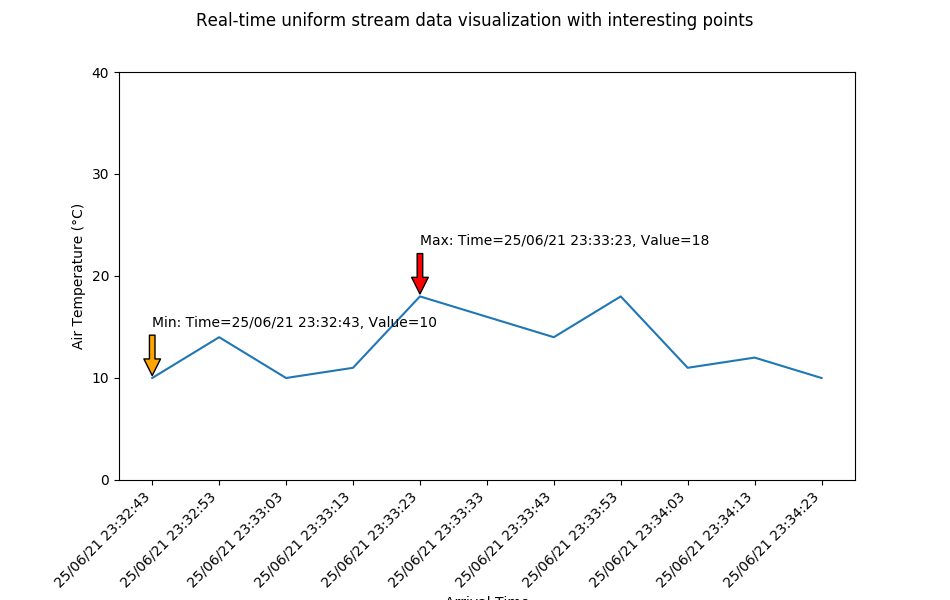

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'StopFire'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('air_temperature_celcius')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.autofmt_xdate(rotation=45)
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    
    except Exception as ex:
        print(str(ex))
        
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            data = eval(data)
            
            if data['producer'] == 1:
                x.append(data['created_date']) 
                y.append(int(data['air_temperature_celcius']))
            
            #print("x:",x,"\n")
            #print("y:",y,"\n")
            
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature (°C)')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,10,20,30,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.autofmt_xdate(rotation=45)
                fig.show() # displaying the figure
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))

if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## Static data visualization from data in MongoDB

In [2]:
# Importing necesarry libraries
import pymongo
from pymongo import MongoClient
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
import folium

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

In [3]:
# Accessing database
client = MongoClient()
db = client.stopfire_db
collection = db.data

### a. Plot a bar chart to visualize the total number of fire records based on each hour
Hour data for this visualisation is using simulation data streaming

<IPython.core.display.Javascript object>


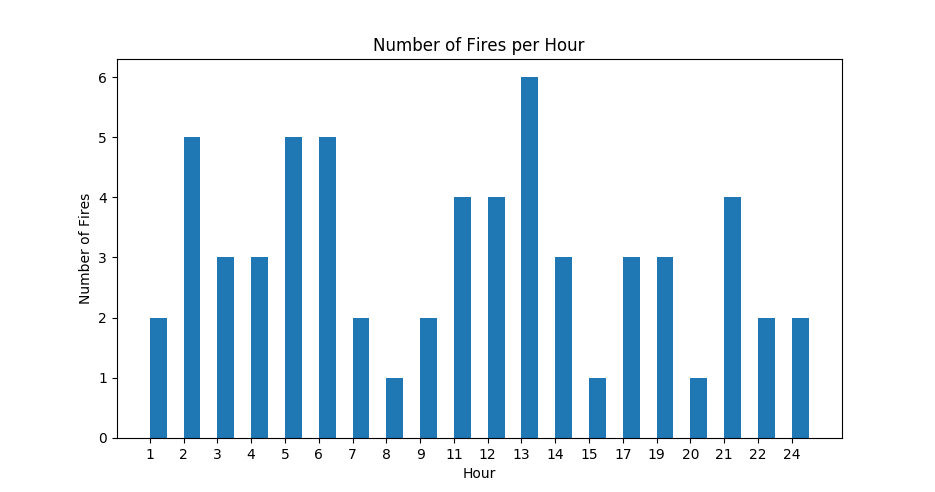

In [5]:
cursor = collection.aggregate([{'$unwind':'$hotspot'},
                              {'$group':{'_id':'$hotspot.hour',
                                         'count':{'$sum':1}}}])
my_list = {}
for document in cursor: 

    hour = document['_id']
    count = int(document['count'])
    
    if hour is not None:
        my_list[hour] = count

# plot graph
plt.figure(figsize=(15, 6))
plt.xticks(range(len(my_list.keys())), my_list)
plt.bar(range(len(my_list)), my_list.values(), align='edge', width=0.5)

plt.xlabel('Hour')
plt.ylabel('Number of Fires')
plt.title('Number of Fires per Hour')
plt.show()

## b. Map Visualisation

- Marker color: ‘blue’ marker if the cause of the fire was ‘natural’, else 'red'
- Marker tooltip information: air temperature, surface temperature, relative humidity, and confidence

In [8]:
def map_plot(data):
    m = folium.Map(location=[-38.043995, 145.264296], zoom_start = 8) # Starting on Melbourne City
    
    # plot market in the map
    
    for doc in data:
        # Get necessary information of 
        latitude = doc['hotspot']['latitude']
        longitude = doc['hotspot']['longitude']
        
        air_temp = str(doc['air_temperature_celcius'])
        surf_temp = str(doc['hotspot']['surface_temperature_celcius'])
        hum = str(doc['relative_humidity'])
        conf = str(doc['hotspot']['confidence'])
        
        msg = "Air Temperature (°C) : {}\nSurface Temperature (°C): {}\nRelative Humidity: {}\nConfidence: {}".format(air_temp, surf_temp, hum, conf)
        iframe = folium.IFrame(msg, width=300, height=90)
        popup = folium.Popup(iframe)
        
        if doc['fire_cause'] == 'natural':
            icon = folium.Icon(color='blue')
        else:
            icon = folium.Icon(color='red')
        
        folium.Marker([latitude, longitude], popup = popup, icon=icon).add_to(m)
    
    return m

if __name__ == '__main__':
    # Read the record
    cursor = collection.aggregate([{"$unwind": "$hotspot"}])
    
    plot_map = map_plot(cursor)
    
    display(plot_map)